In [1]:
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import statsmodels.formula.api as smf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy

In [2]:
DATA_PATH = os.path.join("..", "..", "..", "data")  # document-wide constants are uppercase by convention

 # 1
 ## c: Correlograms for simulated AR, MA, and ARMA processes

In [3]:
df = pd.read_csv(os.path.join(DATA_PATH, "simulated_data.csv"))
df.head()

,AR1,ARMA11,MA1
0,0.000000,0.000000,0.000000
1,-0.984864,0.646808,3.575671
2,1.734153,1.004094,1.859926
3,1.597606,-0.080841,-0.622405
4,-0.549660,2.752125,0.481577


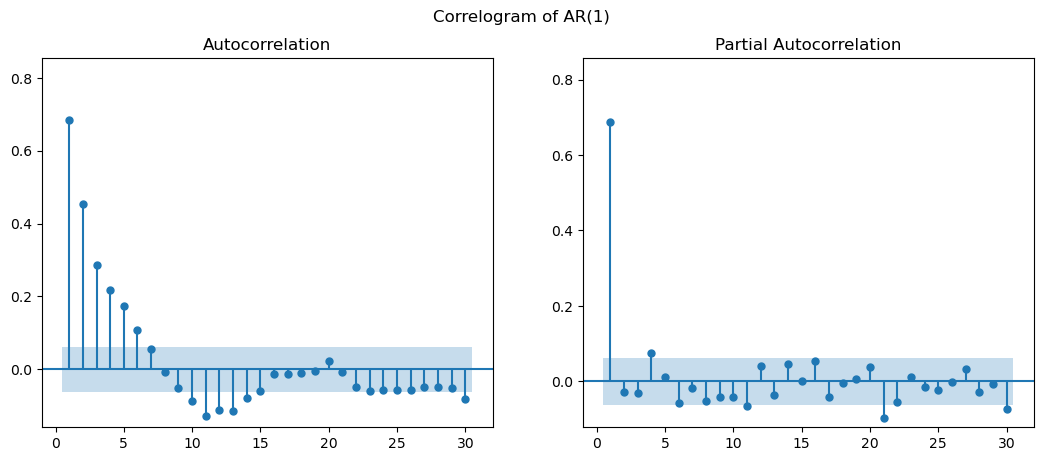

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))
fig.suptitle('Correlogram of AR(1)')
sm.graphics.tsa.plot_acf(df["AR1"], ax=ax1, bartlett_confint=False, zero=False, auto_ylims=True)
sm.graphics.tsa.plot_pacf(df["AR1"], ax=ax2, zero=False, auto_ylims=True, method="ols-inefficient");
fig.savefig("correlogram_ar1.pdf")

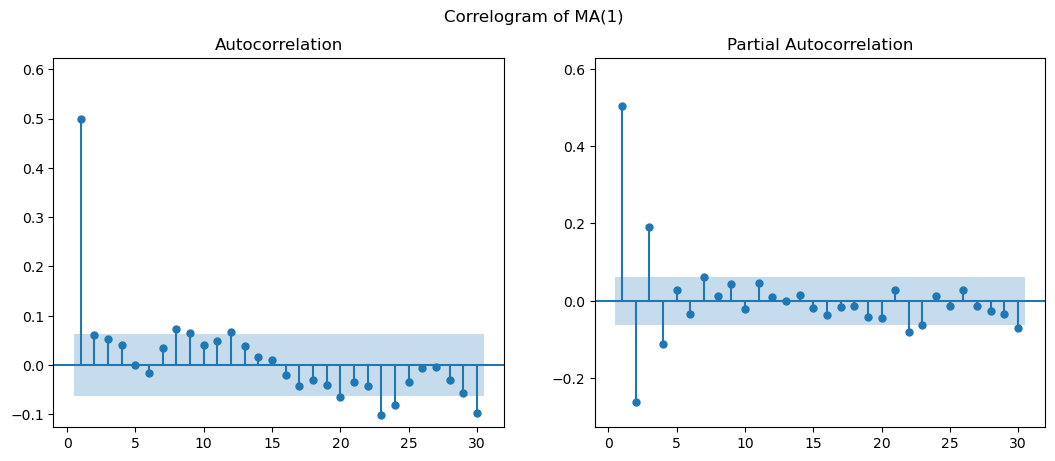

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))
fig.suptitle('Correlogram of MA(1)')
sm.graphics.tsa.plot_acf(df["MA1"], ax=ax1, bartlett_confint=False, zero=False, auto_ylims=True)
sm.graphics.tsa.plot_pacf(df["MA1"], ax=ax2, zero=False, auto_ylims=True, method="ols-inefficient");
fig.savefig("correlogram_ma1.pdf")

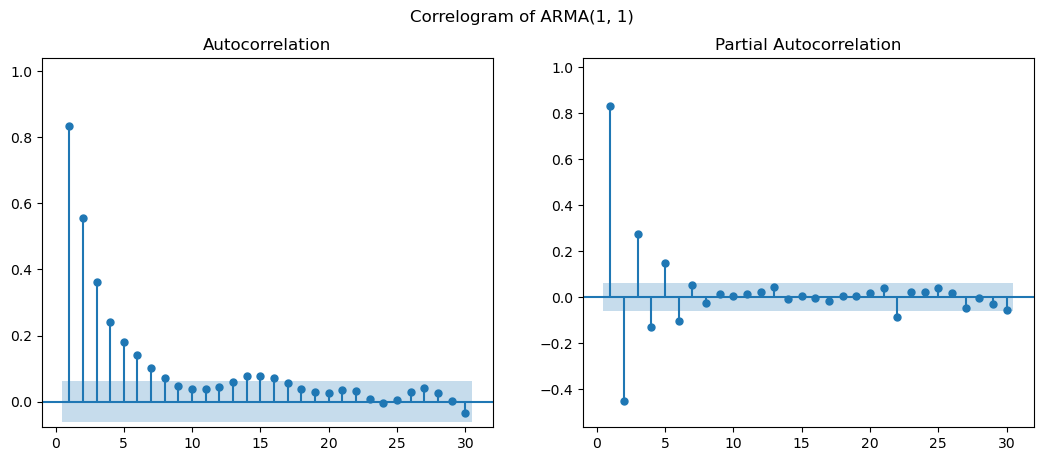

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))
fig.suptitle('Correlogram of ARMA(1, 1)')
sm.graphics.tsa.plot_acf(df["ARMA11"], ax=ax1, bartlett_confint=False, zero=False, auto_ylims=True)
sm.graphics.tsa.plot_pacf(df["ARMA11"], ax=ax2, zero=False, auto_ylims=True, method="ols-inefficient");
fig.savefig("correlogram_arma11.pdf")

For the AR(1), we see that the SACF decays geometrically, while the SPACF drops to zero (more or less) after 1 lag. For the MA(1), we see that the picture is reversed (the fact that the sign of the SPACF alternates does not play a role, as long as its absolute value decays geometrically). For the ARMA(1, 1), both SACF and SPACF decay geometrically, so it's impossible to determine the order of an ARMA($p$, $q$) process (here, $p=1$ and $q=1$) from the correlogram.

# 2
## a: Box-Jenkins procedure
We start by taking a look at the correlogram. Before we do this, we transform the GDP data into growth rates.    

In [7]:
df = pd.read_csv(os.path.join(DATA_PATH, "realgdpch.csv"), index_col="DATE")
df.index = pd.DatetimeIndex(df.index, dayfirst=True).to_period('Q')  # make sure the index is treated as quarterly
df["YoY_GROWTH"] = np.log(df["REAL_GDP"]) - np.log(df["REAL_GDP"]).shift(4)
df.dropna(inplace=True)
df.head()

,REAL_GDP,YoY_GROWTH
DATE,,
1981Q1,90875.9,0.011078
1981Q2,94690.2,0.022135
1981Q3,94119.4,0.022205
1981Q4,97002.0,0.008240
1982Q1,91422.8,0.006000


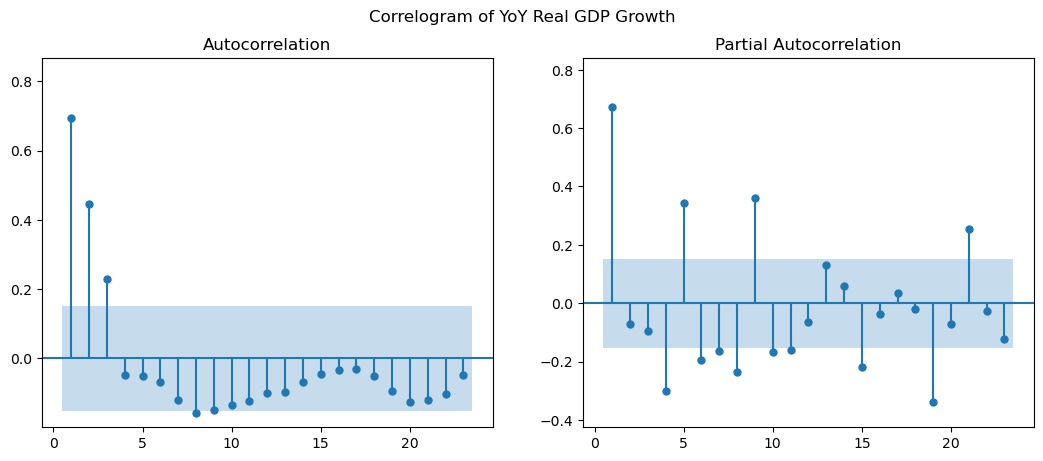

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))
fig.suptitle('Correlogram of YoY Real GDP Growth')
sm.graphics.tsa.plot_acf(df["YoY_GROWTH"], ax=ax1, bartlett_confint=False, zero=False, auto_ylims=True)
sm.graphics.tsa.plot_pacf(df["YoY_GROWTH"], ax=ax2, zero=False, auto_ylims=True, method="ols-inefficient");

We see that the ACF decays geometrically, while the PACF drops to zero after one lag (even though some later values are significant). Still, a simple AR(1) might suffice. We can estimate it using `ARIMA` from `statsmodels.tsa.arima.model`. An ARIMA model generalizes AR, MA, and ARMA models in a way to be discussed next week. For now, suffice it to say that the model takes a tuple `(p, d, q)` as input; `p` is the AR order, `q` is the MA order, and we'll just set `d` to zero for now. Hence, an AR(1) is obtained with `order=(1, 0, 0)`, an MA(1) with `order=(0, 0, 1)`, and an ARMA(1, 1) with `order=(1, 0, 1)`.

In [9]:
mod1 = ARIMA(df.YoY_GROWTH, order=(1, 0, 0)).fit()
print(mod1.summary())

                               SARIMAX Results                                
Dep. Variable:             YoY_GROWTH   No. Observations:                  166
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 468.775
Date:                Mon, 02 Oct 2023   AIC                           -931.550
Time:                        18:39:55   BIC                           -922.214
Sample:                    03-31-1981   HQIC                          -927.760
                         - 06-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0173      0.004      4.447      0.000       0.010       0.025
ar.L1          0.6916      0.042     16.447      0.000       0.609       0.774
sigma2         0.0002   8.09e-06     25.405      0.0

The estimated AR(1) coefficient is $\widehat{\phi}_1=0.6963$, and it is significant. In order to verify that our model captures all the structure of the data, we look at the correlogram of the residuals.

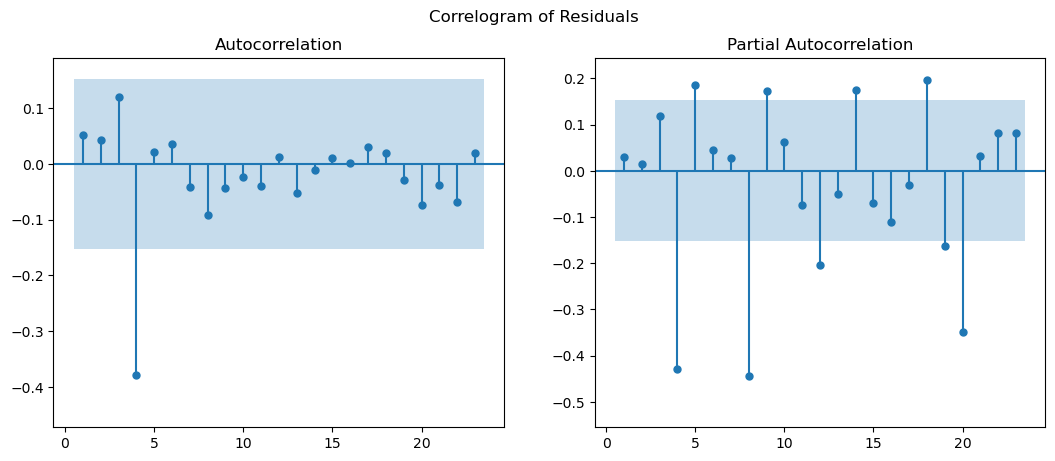

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))
fig.suptitle('Correlogram of Residuals')
sm.graphics.tsa.plot_acf(mod1.resid, ax=ax1, bartlett_confint=False, zero=False, auto_ylims=True)
sm.graphics.tsa.plot_pacf(mod1.resid, ax=ax2, zero=False, auto_ylims=True, method="ols-inefficient");

The ACF and PACF at lag 4 are both significant, so the model needs to be extended. However, it's not obvious which model to use for this. One idea is to use an ARMA(1, 4). This yields the results below.

                               SARIMAX Results                                
Dep. Variable:             YoY_GROWTH   No. Observations:                  166
Model:                 ARIMA(1, 0, 4)   Log Likelihood                 505.331
Date:                Mon, 02 Oct 2023   AIC                           -996.662
Time:                        18:39:56   BIC                           -974.879
Sample:                    03-31-1981   HQIC                          -987.820
                         - 06-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0178      0.001     16.493      0.000       0.016       0.020
ar.L1          0.8862      0.063     14.042      0.000       0.762       1.010
ma.L1         -0.0200      0.166     -0.120      0.9

/home/broda/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


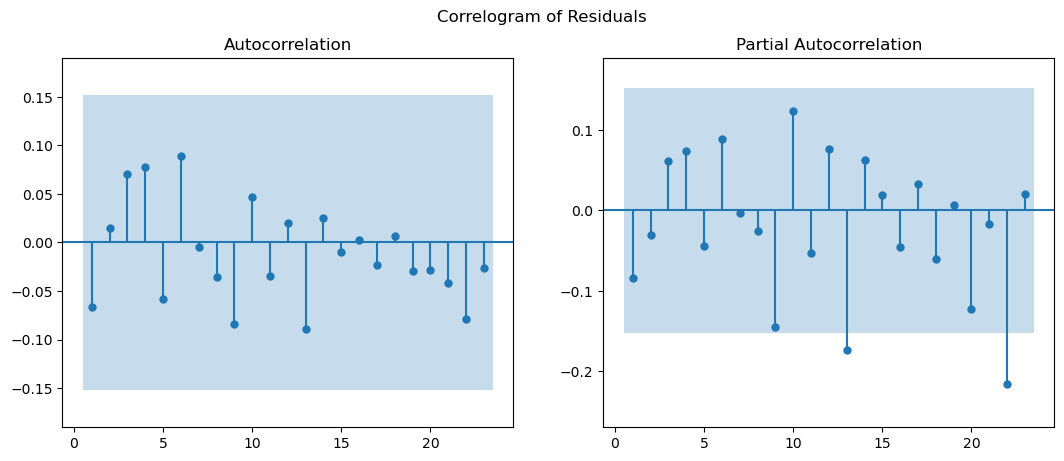

In [11]:
mod2 = ARIMA(df.YoY_GROWTH, order=(1, 0, 4)).fit()
print(mod2.summary())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))
fig.suptitle('Correlogram of Residuals')
sm.graphics.tsa.plot_acf(mod2.resid, ax=ax1, bartlett_confint=False, zero=False, auto_ylims=True)
sm.graphics.tsa.plot_pacf(mod2.resid, ax=ax2, zero=False, auto_ylims=True, method="ols-inefficient");

Ignoring the warning, the residuals look much better now. The AIC and BIC also favor the ARMA(1, 4) specification; e.g., the BIC is -922.214 for the AR(1), and -974.879 for the ARMA(1, 4). It is noteworthy though that the MA terms are all insignificant ($p$-values > 0.05), but apparently the MA terms are still necessary to combat the autocorrelation.

Ordinarily, one would stop here after having found a suitable model. However, some more experimentation shows that an MA(3) model also produces residuals that look good, has an even lower BIC, and its parameters are mostly significant:

                               SARIMAX Results                                
Dep. Variable:             YoY_GROWTH   No. Observations:                  166
Model:                 ARIMA(0, 0, 3)   Log Likelihood                 502.568
Date:                Mon, 02 Oct 2023   AIC                           -995.136
Time:                        18:39:56   BIC                           -979.576
Sample:                    03-31-1981   HQIC                          -988.820
                         - 06-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0174      0.004      3.973      0.000       0.009       0.026
ma.L1          0.8870      0.033     26.865      0.000       0.822       0.952
ma.L2          0.8976      0.063     14.209      0.0

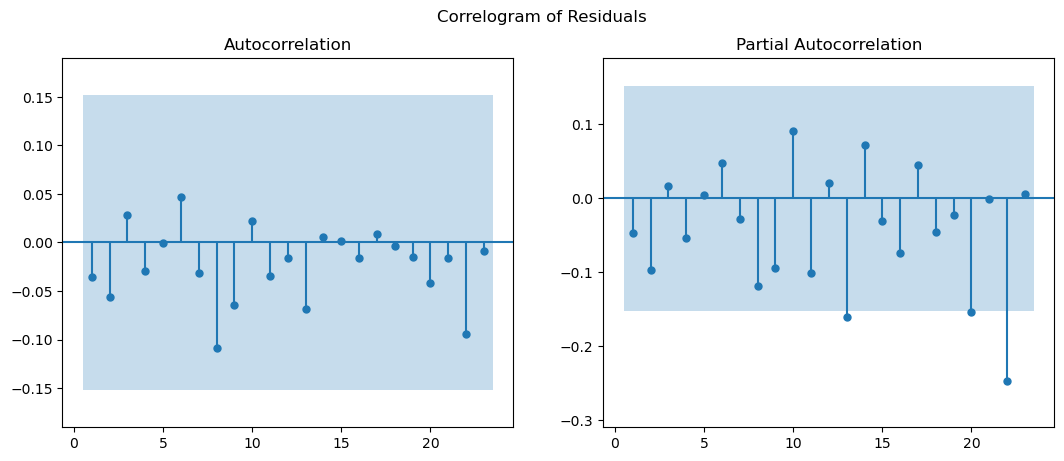

In [12]:
mod3 = ARIMA(df.YoY_GROWTH, order=(0, 0, 3)).fit()
print(mod3.summary())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))
fig.suptitle('Correlogram of Residuals')
sm.graphics.tsa.plot_acf(mod3.resid, ax=ax1, bartlett_confint=False, zero=False, auto_ylims=True)
sm.graphics.tsa.plot_pacf(mod3.resid, ax=ax2, zero=False, auto_ylims=True, method="ols-inefficient");

The reason that the BIC prefers this model is that it is more parsimonious, as it saves two parameters ($p+q=3$ for the MA(3), while of $p+q=5$ for the ARMA(1, 4). 

Finally, we can test formally whether the autocorrelations in the model are *jointly* significant, by using the Ljung-Box test. The test is the same as the one intruced last week, but as discussed in the slides, the fact that we are now dealing with residuals instead of raw data changes the degrees of freedom from $m$ to $m-p-q$. We can take this into account by passing the optional argument `model_df=3` into `acorr_ljungbox`, since $p=0$ and $q=3$, so $p+q=3$.

In [13]:
acorr_ljungbox(mod3.resid, model_df = 3)

,lb_stat,lb_pvalue
1,0.213131,NaN
2,0.738852,NaN
3,0.876168,NaN
4,1.027591,0.310725
5,1.027605,0.598217
6,1.414086,0.702236
7,1.592691,0.810105
8,3.677667,0.596691
9,4.410233,0.621342
10,4.494796,0.721344


The results look fine; no $p$-value is less than 5%. The fact that the first 3 $p$-values cannot be computed is q consequence of the fact that `model_df = 3`.

# 2
## b: Forecasting
### i) MA(3)
For convencience, let's display our estimated parameters for the MA(3) model again:

In [14]:
mod3.params

const     0.017379
ma.L1     0.886956
ma.L2     0.897601
ma.L3     0.857007
sigma2    0.000133
dtype: float64

Here, `ma.L1` corresponds to $\theta_1$, and so on. This means that our estimated model is 

$$Y_t = 0.017379 + 0.886956 \cdot U_{t-1} + 0.897601 \cdot U_{t-2} + 0.857007 \cdot U_{t-3} + U_t,$$
which means that
$$Y_{2022Q3} = 0.017379 + 0.886956 \cdot U_{2022Q2} + 0.897601 \cdot U_{2022Q1} + 0.857007 \cdot U_{2021Q4} + U_{2022Q3}.$$

Recall our strategy: replace past $U_t$ with estimates and future $U_t$ with their expectation, zero. The estimated residuals are

In [15]:
mod3.resid.tail()

DATE
2021Q2    0.026743
2021Q3   -0.001900
2021Q4    0.000790
2022Q1    0.003805
2022Q2    0.004202
Freq: Q-DEC, dtype: float64

Plugging in, we find that
$$\widehat{Y}_{2022Q3} = 0.017379 + 0.886956 \cdot 0.004202 + 0.897601 \cdot 0.003805 + 0.857007 \cdot 0.000790 + 0 = 0.025199,$$ which we can confirm with

In [16]:
mod3.predict("2022Q3")

2022Q3    0.025199
Freq: Q-DEC, dtype: float64

For the two-period forecast, we have
$$Y_{2022Q4} = 0.017379 + 0.886956 \cdot U_{2022Q3} + 0.897601 \cdot U_{2022Q2} + 0.857007 \cdot U_{2022Q1} + U_{2022Q4}.$$
Now both $U_{2022Q3}$ and $U_{2022Q4}$ are unknown and must be replaced with 0. Hence
$$\widehat{Y}_{2022Q4} = 0.017379 + 0 + 0.897601 \cdot 0.004202 + 0.857007 \cdot 0.003805 + 0 = 0.024412.$$
We can again confirm this with

In [17]:
mod3.predict("2022Q4")

2022Q4    0.024412
Freq: Q-DEC, dtype: float64

### ii) AR(1)

The forecasting strategy for AR and ARMA models is the same, in principle, as for MA models. However, it must be noted that the constant that `statsmodels` returns does not correspond to our $\alpha$. Instead, the estimated constant `const` corresponds to $\mathbb{E}[Y_t]=\alpha/(1-\phi_1)$, so in our notation, $\hat{\alpha}=\mathtt{const}\cdot(1-\hat{\phi}_1)$. 

Looking at our estimated AR(1) parameters again via

In [18]:
mod1.params

const     0.017258
ar.L1     0.691620
sigma2    0.000205
dtype: float64

this means that $\hat{\alpha}=0.017258\cdot(1-0.691620)=0.005322$, so that our estimated model is
$$Y_t = 0.005322 + 0.691620 \cdot Y_{t-1} + U_t.$$
Thus, plugging in and setting future $U_t$ to zero,

$$\widehat{Y}_{2022Q3} = 0.005322 + 0.691620 \cdot {Y}_{2022Q2} + 0 = 0.005322 + 0.691620 \cdot 0.024037 = 0.021947,$$ where we obtained ${Y}_{2022Q2}$ from

In [19]:
df.tail(1)

,REAL_GDP,YoY_GROWTH
DATE,,
2022Q2,190906.9,0.024037


As before, we can confirm our calculation with

In [20]:
mod1.predict("2022Q3")

2022Q3    0.021947
Freq: Q-DEC, dtype: float64

For the two-step forecast, we'd ideally want to use
$$\widehat{Y}_{2022Q4} = 0.005322 + 0.691620 \cdot {Y}_{2022Q3} + 0,$$
but ${Y}_{2022Q3}$ is obviously not available; thus, we just replace it with our previous forecast. This yields
$$\widehat{Y}_{2022Q4} = 0.005322 + 0.691620 \cdot \widehat{Y}_{2022Q3} = 0.005322 + 0.691620 \cdot 0.021947 = 0.020501,$$
which we can confirm with 

In [21]:
mod1.predict("2022Q4")

2022Q4    0.020501
Freq: Q-DEC, dtype: float64

as usual.